# Metadata

```yaml
Course:    DS 5001
Module:    09 Lab
Topic:     Word2Vec
Author:    R.C. Alvarado
Date:      27 March 2024 (revised)
```

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
# Adjust this for a new corpus
data_prefix = 'novels'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['book', 'chapter', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA
# BAG = SENT

In [3]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE
import plotly_express as px

In [5]:
import gensim
gensim.__version__

'4.3.0'

# Import `TOKENS` and `VOCAB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [6]:
TOKENS = pd.read_csv(f'{table_dir}/{data_prefix}-TOKENS.csv').set_index(OHCO)

In [7]:
TOKENS.head()

pos     term_str  term_id
book            chapter para_num sent_num token_num                           
secretadversary 1       0        1        0           DT          the    24127
                                          1          NNP        young    27354
                                          2          NNP  adventurers      399
                                          3          NNP          ltd    14406
                        1        0        0           JJ        tommy    24529

In [8]:
VOCAB = pd.read_csv(f'{table_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

In [9]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [10]:
VOCAB.sample(5)

,term_id,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max,pos_max
term_str,,,,,,,,,,,
doge,7243,1,6.664814e-07,doge,0,1,2.505150,2.505150,0.007829,2.505150,NNP
thirty,24228,57,3.798944e-05,thirti,0,39,0.914085,52.102866,0.162821,3.656341,NN
rambler,19221,1,6.664814e-07,rambler,0,1,2.505150,2.505150,0.007829,2.505150,NNP
farthing,9052,5,3.332407e-06,farth,0,3,2.028029,10.140144,0.031688,6.084086,NN
uncensured,25263,1,6.664814e-07,uncensur,0,1,2.505150,2.505150,0.007829,2.505150,JJ


# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [11]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset='term_str')\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [12]:
print(docs[:2])

[['to', 'she', 'is', 'always', 'woman'], ['i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'name']]


In [13]:
vocab = Dictionary(docs)

# Generate word embeddings with Gensim's module

In [14]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [15]:
model.wv.vectors

array([[-6.14058137e-01,  1.79028451e-01,  5.05454600e-01, ...,
         6.58875257e-02,  3.31388623e-01, -4.81176883e-01],
       [ 1.32089615e-01, -5.09236813e-01, -1.18525743e+00, ...,
        -4.24856216e-01,  2.07516029e-01, -2.21059278e-01],
       [-2.98763543e-01, -6.13290489e-01,  1.03149384e-01, ...,
        -4.37035948e-01,  7.91104078e-01,  5.75523339e-02],
       ...,
       [ 1.48438632e-01, -1.15089461e-01, -1.28254235e-01, ...,
        -1.20259732e-01,  5.56110181e-02,  1.53016359e-01],
       [ 6.64673629e-04, -2.23794077e-02,  1.08937442e-01, ...,
        -5.90645336e-02,  2.29354188e-01, -7.05981404e-02],
       [ 1.65760979e-01, -1.20679595e-01,  1.03224404e-02, ...,
         1.64210483e-01,  8.43123998e-03, -1.52940024e-02]], dtype=float32)

# Visualize with tSNE

## Convert model to data frame

In [16]:
# VOCAB['gsid'] = pd.DataFrame([i for i in vocab.items()], columns=['gsid', 'term_str']).set_index('term_str')
# VOCAB = VOCAB.dropna(subset='gsid').copy()
# VOCAB.gsid = VOCAB.gsid.astype(int)

In [17]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [18]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [19]:
WV

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
term_str,,,,,,,,,,,,,,,,,,,,,
a,-0.379742,0.301728,0.158096,0.705950,-0.438131,0.046930,-0.260591,-0.477729,-0.065019,0.430079,...,-0.510434,-0.338280,-0.269626,-0.072290,-0.064311,0.120449,-0.553333,-0.196511,-0.376084,-1.079587
abandoned,-0.003998,-0.168023,0.061687,0.051514,-0.104999,-0.062013,-0.240809,-0.094496,-0.136050,-0.170349,...,-0.076192,0.040730,-0.064725,-0.090285,0.189100,0.055290,0.095665,-0.018128,0.028126,-0.004440
abbess,-0.111249,-0.053931,-0.065518,0.018786,0.015144,-0.029203,-0.215439,-0.093365,0.020809,-0.054286,...,0.084345,0.035042,0.016227,-0.020432,0.018270,0.035676,-0.046419,0.061412,0.081474,0.027572
able,0.295437,-0.972174,0.066527,0.260782,-0.004025,-0.375991,-0.836072,-0.099750,-0.304999,0.110054,...,-0.249405,0.893199,-0.174862,0.343002,0.104064,0.366359,-0.276657,-0.114239,0.001504,0.260114
about,-0.174433,0.177933,-0.163863,0.185015,0.570673,-0.214406,0.139340,-0.410560,-0.055060,0.249251,...,0.603519,-0.102837,0.188134,-0.638281,-0.015310,0.058535,0.121384,0.113131,-0.122893,0.055937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youre,0.159005,0.060432,-0.259548,-0.073706,0.063195,0.061335,-0.118916,0.191503,-0.177326,0.099627,...,0.104722,0.153546,-0.256999,0.039461,-0.375601,-0.289462,0.005885,0.224570,-0.258368,0.247823
yours,-0.092059,-0.245771,0.092565,0.009897,0.082552,-0.014297,-0.304266,-0.126994,0.084394,0.058037,...,-0.143441,-0.000897,-0.181559,0.164035,-0.086627,-0.046411,-0.040346,0.018568,-0.317535,-0.007125
yourself,0.072123,-0.214210,-0.512157,0.069380,0.548011,0.453610,-0.363442,0.388794,0.057270,-0.265104,...,-0.111257,0.354542,-0.247514,0.517402,-0.432582,0.121198,-0.411580,0.231190,-1.061688,0.217055


## Use ScikitLearn's TSNE library

In [20]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [21]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [22]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [23]:
TSNE

,x,y
term_str,,
a,-21.784590,-28.473755
abandoned,4.337274,-21.837189
abbess,-0.954303,6.983067
able,-1.585088,-28.302372
about,-26.939096,-28.351446
...,...,...
youre,22.042049,-25.484022
yours,23.702435,-16.190260
yourself,40.492184,7.588075


## Plot the coordinates

In [24]:
X = TSNE.join(VOCAB, how='left')

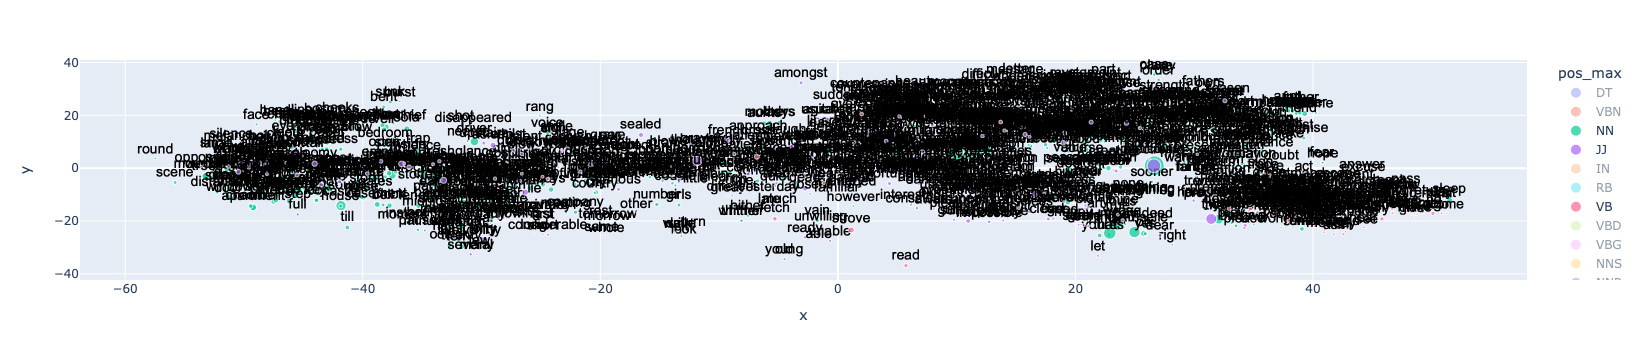

In [78]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_max', 
           hover_name='term_str',          
           size='tfidf_max',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [79]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [27]:
complete_analogy('man', 'boy', 'woman', 3)

,term,sim
0,girl,0.788894
1,peasant,0.695336
2,lady,0.691587


In [28]:
complete_analogy('girl', 'daughter', 'boy', 3)

,term,sim
0,wife,0.793933
1,master,0.788670
2,uncle,0.777100


In [29]:
complete_analogy('girl', 'sister', 'boy', 3)

,term,sim
0,master,0.827114
1,cousin,0.781004
2,uncle,0.775325


In [30]:
complete_analogy('man', 'gentleman', 'woman', 5)

,term,sim
0,girl,0.817576
1,peasant,0.734628
2,lady,0.711860
3,fellow,0.697946
4,young,0.687411


In [31]:
complete_analogy('man', 'woman', 'gentleman', 5)

,term,sim
0,girl,0.817576
1,peasant,0.734628
2,lady,0.711860
3,fellow,0.697946
4,young,0.687411


In [32]:
complete_analogy('woman', 'man', 'lady', 5)

,term,sim
0,boy,0.688065
1,gentleman,0.687583
2,doctor,0.680753
3,friend,0.663397
4,master,0.645334


In [33]:
complete_analogy('day', 'night', 'sun', 5)

,term,sim
0,rain,0.842176
1,gates,0.826084
2,twilight,0.812911
3,wind,0.806102
4,clouds,0.798691


In [70]:
complete_analogy('woman','answered','man', 5)

,term,sim
0,replied,0.672718
1,says,0.669190
2,said,0.659242
3,remarked,0.644187
4,saying,0.643100


In [71]:
complete_analogy('man','replied','woman', 5)

,term,sim
0,answered,0.724682
1,truly,0.693492
2,exclaimed,0.690616
3,oh,0.684583
4,thinks,0.681336


In [72]:
complete_analogy('wife', 'appeared', 'husband', 5)

,term,sim
0,seemed,0.802784
1,proved,0.640243
2,believed,0.630207
3,considered,0.607803
4,experienced,0.591214


In [73]:
complete_analogy('husband', 'appeared', 'wife', 5)

,term,sim
0,seemed,0.663734
1,distinguished,0.621346
2,succeeded,0.598477
3,perceived,0.584147
4,sought,0.571337


In [74]:
complete_analogy('man', 'father', 'woman', 5)

,term,sim
0,mother,0.849328
1,husband,0.845066
2,aunt,0.827155
3,niece,0.778856
4,daughter,0.753705


In [75]:
complete_analogy('man', 'husband', 'woman', 5)

,term,sim
0,mother,0.820475
1,aunt,0.816916
2,niece,0.784000
3,father,0.778376
4,daughter,0.731512


In [76]:
complete_analogy('man', 'castle', 'woman', 5)

,term,sim
0,house,0.698088
1,convent,0.684274
2,chateau,0.657860
3,church,0.635959
4,village,0.624091


In [77]:
complete_analogy('woman', 'home', 'man', 5)

,term,sim
0,ready,0.675226
1,station,0.650292
2,rest,0.645577
3,off,0.613166
4,morrow,0.599513


## Similarites

In [34]:
get_most_similar('joy')

,term,sim
0,tender,0.858178
1,despair,0.857970
2,grief,0.857926
3,indignation,0.857510
4,astonishment,0.853664
5,tenderness,0.851100
6,terror,0.849428
7,admiration,0.849296
8,anguish,0.843757
9,sweetness,0.842490


In [35]:
get_most_similar('man')

,term,sim
0,gentleman,0.848631
1,woman,0.808404
2,girl,0.726127
3,fellow,0.724440
4,person,0.703364
5,creature,0.700765
6,peasant,0.667488
7,stranger,0.643133
8,lady,0.621768
9,doctor,0.620519


In [36]:
get_most_similar(positive=['man'], negative=['woman'])

,term,sim
0,he,0.334811
1,order,0.320915
2,case,0.316780
3,his,0.313891
4,rest,0.301026
5,police,0.294852
6,off,0.278098
7,key,0.275395
8,them,0.271355
9,run,0.268759


In [37]:
get_most_similar(positive='woman')

,term,sim
0,gentleman,0.847215
1,girl,0.842816
2,man,0.808404
3,creature,0.772356
4,fellow,0.743919
5,peasant,0.736655
6,lady,0.694711
7,stranger,0.691583
8,poor,0.653012
9,servant,0.649272


In [38]:
get_most_similar(positive=['woman'], negative=['man'])

,term,sim
0,sweet,0.447657
1,revived,0.426239
2,looks,0.409627
3,beloved,0.409554
4,dreadful,0.403111
5,lovely,0.396790
6,extremely,0.389243
7,painful,0.385851
8,shocked,0.383459
9,terror,0.382382


In [39]:
get_most_similar(['man','woman'],['boy','girl'])

,term,sim
0,or,0.446157
1,nor,0.434149
2,human,0.412443
3,such,0.387991
4,than,0.383221
5,produce,0.377250
6,even,0.377130
7,person,0.373402
8,avoid,0.355799
9,render,0.342168


# View with HAC

In [67]:
import sys
sys.path.append(local_lib)
from hac import HAC

In [68]:
WV2 = WV.join(VOCAB.pos_max)
WV2 = WV2[~WV2.pos_max.str.match(r"NNPS?")].iloc[:, :-1]

<Figure size 640x480 with 0 Axes>

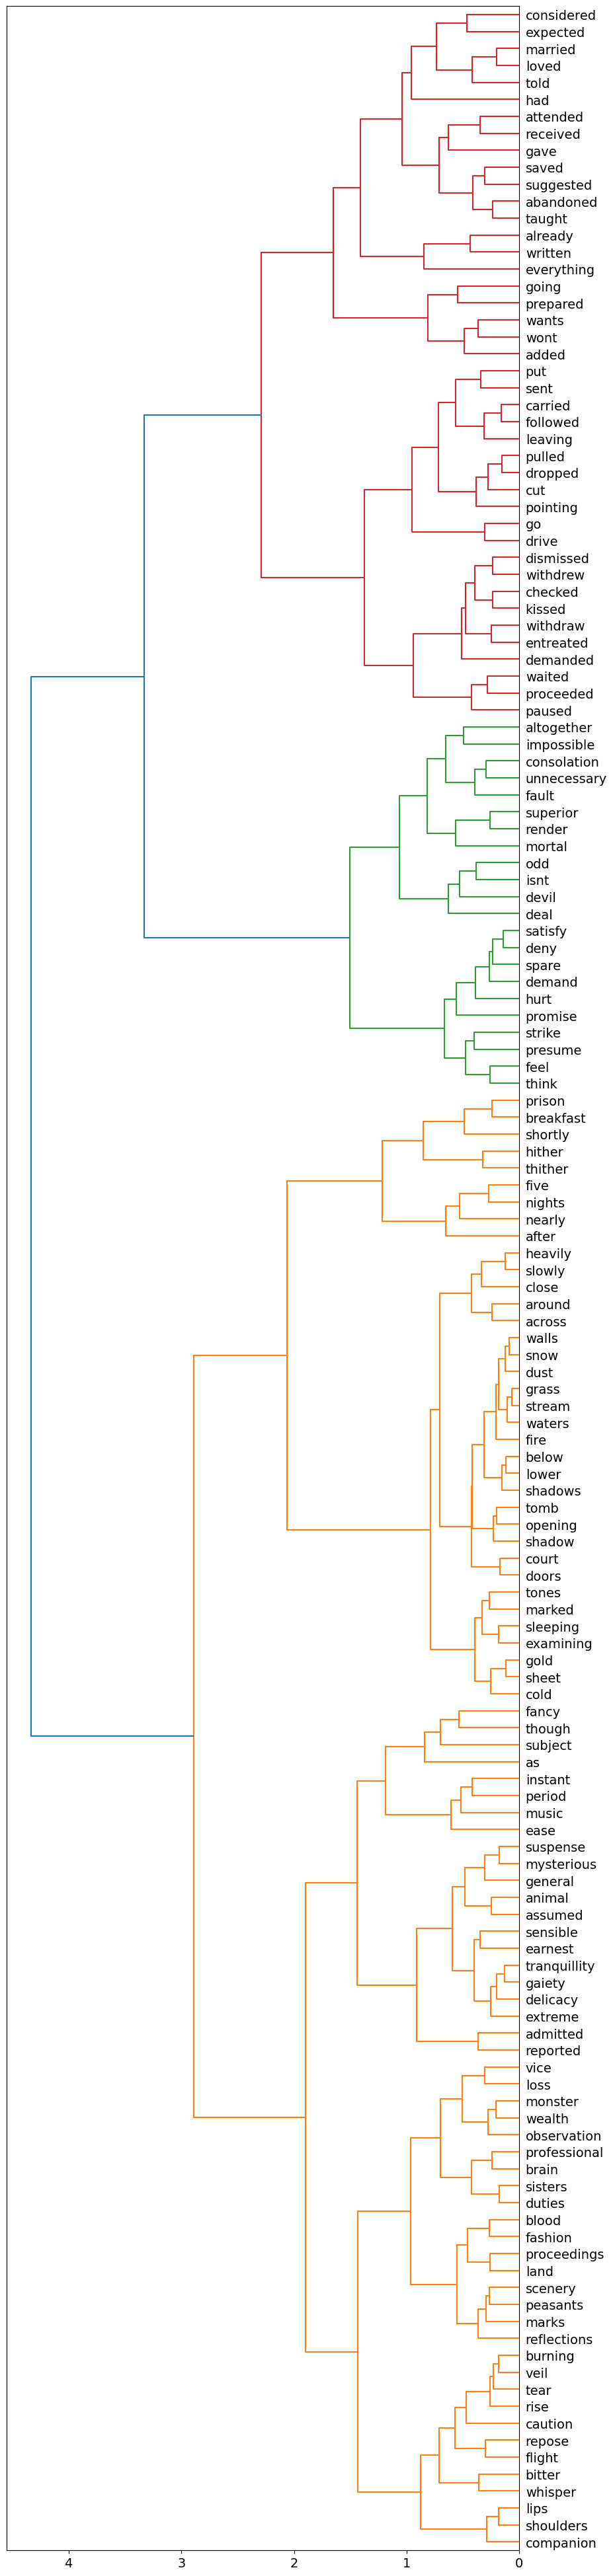

In [69]:
HAC(WV2.sample(150)).plot()

# Save

In [51]:
# W2V = pd.DataFrame(model.wv.vectors_norm, index=model.wv.vocab.keys())
# WV.to_csv('{}/{}-W2V.csv'.format(data_out, data_prefix))
# pd.Series(DOCS).to_csv('{}/{}-GENSIM_DOCS.csv'.format(data_out, data_prefix), index=False, header=False)